# Este material foi extraido do github do autor do livro, e modificado para os propósitos da aula

**Chapter 15 – Processing Sequences Using RNNs and CNNs**

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Basic RNNs

### Generate the Dataset

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


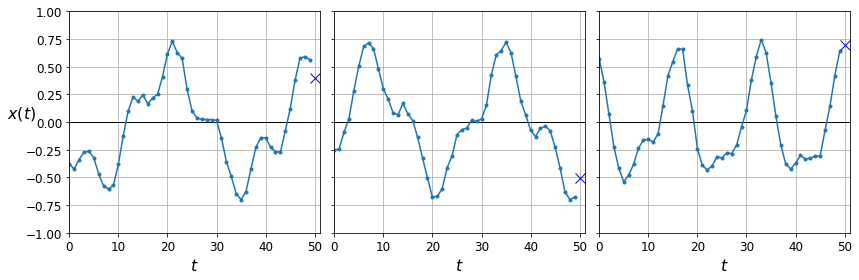

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

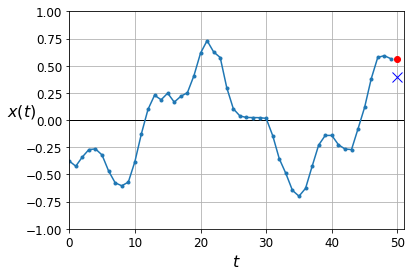

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20, batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 1s 90us/sample - loss: 0.0573 - val_loss: 0.0161
Epoch 2/20
7000/7000 [==============================] - 0s 16us/sample - loss: 0.0116 - val_loss: 0.0099
Epoch 3/20
7000/7000 [==============================] - 0s 17us/sample - loss: 0.0085 - val_loss: 0.0075
Epoch 4/20
7000/7000 [==============================] - 0s 16us/sample - loss: 0.0066 - val_loss: 0.0065
Epoch 5/20
7000/7000 [==============================] - 0s 16us/sample - loss: 0.0057 - val_loss: 0.0054
Epoch 6/20
7000/7000 [==============================] - 0s 16us/sample - loss: 0.0051 - val_loss: 0.0051
Epoch 7/20
7000/7000 [==============================] - 0s 15us/sample - loss: 0.0048 - val_loss: 0.0050
Epoch 8/20
7000/7000 [==============================] - 0s 17us/sample - loss: 0.0046 - val_loss: 0.0045
Epoch 9/20
7000/7000 [==============================] - 0s 16us/sample - loss: 0.0043 - val_loss: 0.0043
Epoch 1

In [9]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 34us/sample - loss: 0.0034


0.0033880958277732135

In [10]:
model.layers[1].get_weights()

[array([[ 9.01719183e-03],
        [ 3.65058593e-02],
        [ 1.17912237e-02],
        [ 2.37232335e-02],
        [-8.89197290e-02],
        [ 4.85421857e-03],
        [ 5.28780818e-02],
        [ 7.48518780e-02],
        [-2.17515938e-02],
        [-1.89230721e-02],
        [-3.94184627e-02],
        [ 2.79331375e-02],
        [-4.36904915e-02],
        [ 1.79504976e-02],
        [ 2.22910801e-03],
        [ 5.94214760e-02],
        [-6.31952137e-02],
        [-8.95072147e-03],
        [-5.66811264e-02],
        [-1.19378351e-01],
        [ 2.19050180e-02],
        [-5.30485646e-04],
        [-4.17731069e-02],
        [-1.13385934e-02],
        [-8.45829919e-02],
        [-1.36706829e-01],
        [-1.26026928e-01],
        [-1.18587926e-01],
        [ 2.28263773e-02],
        [-1.30183781e-02],
        [ 2.23607868e-02],
        [-2.10087880e-01],
        [-1.30808011e-01],
        [-1.81642950e-01],
        [-1.01287842e-01],
        [-5.78932427e-02],
        [ 8.58241022e-02],
 

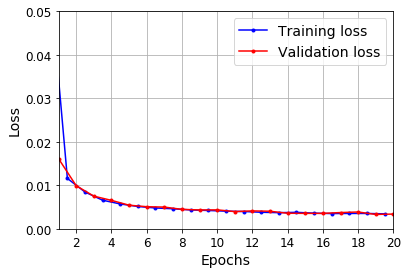

In [11]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

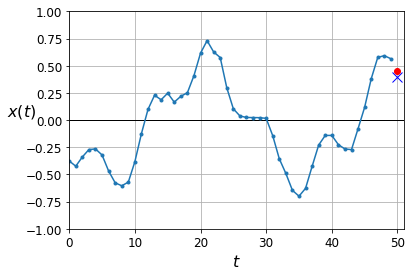

In [12]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

In [61]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [62]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_16 (SimpleRNN)    (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [13]:
optimizer = keras.optimizers.Adam(lr=0.05)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20, batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 2s 245us/sample - loss: 0.0546 - val_loss: 0.0194
Epoch 2/20
7000/7000 [==============================] - 1s 144us/sample - loss: 0.0165 - val_loss: 0.0140
Epoch 3/20
7000/7000 [==============================] - 1s 150us/sample - loss: 0.0132 - val_loss: 0.0119
Epoch 4/20
7000/7000 [==============================] - 1s 149us/sample - loss: 0.0119 - val_loss: 0.0111
Epoch 5/20
7000/7000 [==============================] - 1s 150us/sample - loss: 0.0115 - val_loss: 0.0109
Epoch 6/20
7000/7000 [==============================] - 1s 148us/sample - loss: 0.0114 - val_loss: 0.0109
Epoch 7/20
7000/7000 [==============================] - 1s 146us/sample - loss: 0.0114 - val_loss: 0.0109
Epoch 8/20
7000/7000 [==============================] - 1s 149us/sample - loss: 0.0114 - val_loss: 0.0109
Epoch 9/20
7000/7000 [==============================] - 1s 149us/sample - loss: 0.0114 - val_loss: 0.010

In [14]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 144us/sample - loss: 0.0109


0.010895953722298145

In [15]:
model.layers[0].get_weights()

[array([[1.6578159]], dtype=float32),
 array([[-0.67670476]], dtype=float32),
 array([0.00478511], dtype=float32)]

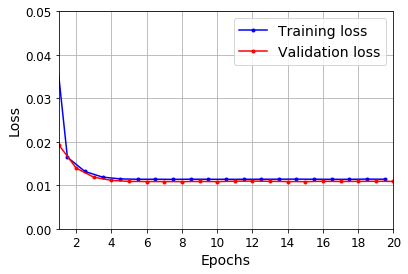

In [16]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

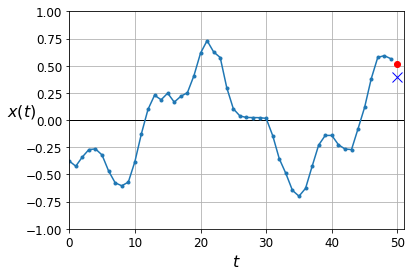

In [17]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [63]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

In [64]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_17 (SimpleRNN)    (None, None, 20)          440       
_________________________________________________________________
simple_rnn_18 (SimpleRNN)    (None, None, 20)          820       
_________________________________________________________________
simple_rnn_19 (SimpleRNN)    (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [18]:
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20, batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 647us/sample - loss: 0.0586 - val_loss: 0.0052
Epoch 2/20
7000/7000 [==============================] - 3s 416us/sample - loss: 0.0047 - val_loss: 0.0046
Epoch 3/20
7000/7000 [==============================] - 3s 419us/sample - loss: 0.0045 - val_loss: 0.0039
Epoch 4/20
7000/7000 [==============================] - 3s 420us/sample - loss: 0.0040 - val_loss: 0.0036
Epoch 5/20
7000/7000 [==============================] - 3s 417us/sample - loss: 0.0038 - val_loss: 0.0035
Epoch 6/20
7000/7000 [==============================] - 3s 416us/sample - loss: 0.0037 - val_loss: 0.0040
Epoch 7/20
7000/7000 [==============================] - 3s 416us/sample - loss: 0.0036 - val_loss: 0.0035
Epoch 8/20
7000/7000 [==============================] - 3s 421us/sample - loss: 0.0036 - val_loss: 0.0032
Epoch 9/20
7000/7000 [==============================] - 3s 422us/sample - loss: 0.0034 - val_loss: 0.003

In [19]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 1s 312us/sample - loss: 0.0028


0.002773296028375626

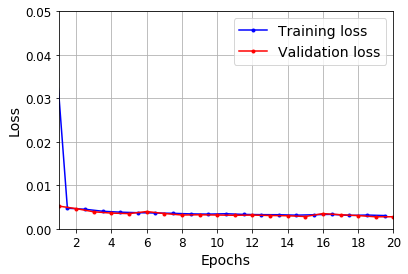

In [20]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

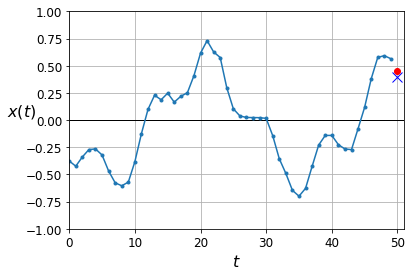

In [21]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Make the second `SimpleRNN` layer return only the last output:

In [22]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20, batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 458us/sample - loss: 0.0294 - val_loss: 0.0041
Epoch 2/20
7000/7000 [==============================] - 2s 292us/sample - loss: 0.0038 - val_loss: 0.0037
Epoch 3/20
7000/7000 [==============================] - 2s 284us/sample - loss: 0.0036 - val_loss: 0.0039
Epoch 4/20
7000/7000 [==============================] - 2s 284us/sample - loss: 0.0035 - val_loss: 0.0031
Epoch 5/20
7000/7000 [==============================] - 2s 285us/sample - loss: 0.0033 - val_loss: 0.0032
Epoch 6/20
7000/7000 [==============================] - 2s 289us/sample - loss: 0.0032 - val_loss: 0.0030
Epoch 7/20
7000/7000 [==============================] - 2s 290us/sample - loss: 0.0032 - val_loss: 0.0033
Epoch 8/20
7000/7000 [==============================] - 2s 282us/sample - loss: 0.0032 - val_loss: 0.0029
Epoch 9/20
7000/7000 [==============================] - 2s 290us/sample - loss: 0.0031 - val_loss: 0.002

In [23]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 233us/sample - loss: 0.0027


0.0026511053880676626

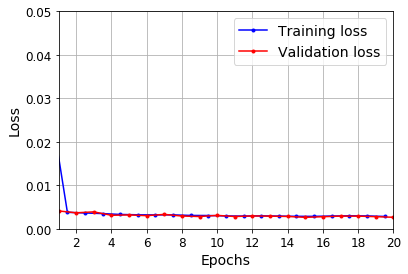

In [24]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

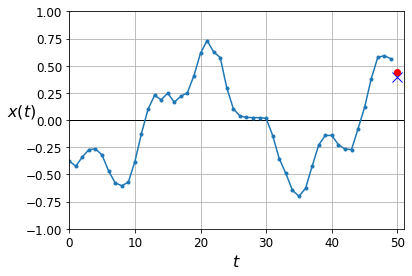

In [25]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [26]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [27]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


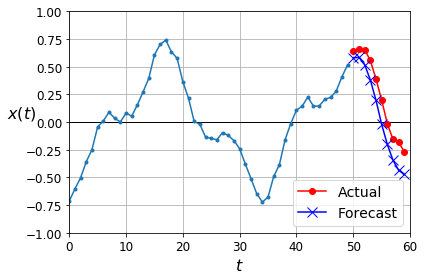

In [28]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [29]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [30]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [31]:
Y_pred.shape

(2000, 10)

In [32]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.028554883

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [33]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, Y_train, epochs=20, batch_size=128,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 0s 53us/sample - loss: 0.0845 - val_loss: 0.0374
Epoch 2/20
7000/7000 [==============================] - 0s 17us/sample - loss: 0.0320 - val_loss: 0.0280
Epoch 3/20
7000/7000 [==============================] - 0s 15us/sample - loss: 0.0260 - val_loss: 0.0243
Epoch 4/20
7000/7000 [==============================] - 0s 15us/sample - loss: 0.0234 - val_loss: 0.0229
Epoch 5/20
7000/7000 [==============================] - 0s 15us/sample - loss: 0.0220 - val_loss: 0.0217
Epoch 6/20
7000/7000 [==============================] - 0s 16us/sample - loss: 0.0210 - val_loss: 0.0203
Epoch 7/20
7000/7000 [==============================] - 0s 15us/sample - loss: 0.0202 - val_loss: 0.0200
Epoch 8/20
7000/7000 [==============================] - 0s 15us/sample - loss: 0.0195 - val_loss: 0.0191
Epoch 9/20
7000/7000 [==============================] - 0s 18us/sample - loss: 0.0189 - val_loss: 0.0187
Epoch 1

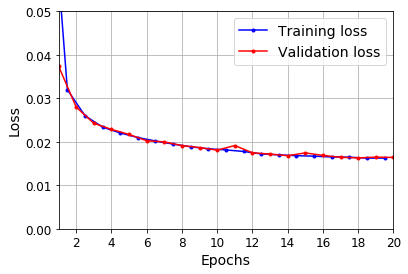

In [35]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

Now let's create an RNN that predicts all 10 next values at once:

In [36]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20, batch_size=128,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 452us/sample - loss: 0.1378 - val_loss: 0.0642
Epoch 2/20
7000/7000 [==============================] - 2s 289us/sample - loss: 0.0481 - val_loss: 0.0391
Epoch 3/20
7000/7000 [==============================] - 2s 286us/sample - loss: 0.0366 - val_loss: 0.0331
Epoch 4/20
7000/7000 [==============================] - 2s 287us/sample - loss: 0.0319 - val_loss: 0.0293
Epoch 5/20
7000/7000 [==============================] - 2s 285us/sample - loss: 0.0278 - val_loss: 0.0247
Epoch 6/20
7000/7000 [==============================] - 2s 281us/sample - loss: 0.0229 - val_loss: 0.0206
Epoch 7/20
7000/7000 [==============================] - 2s 291us/sample - loss: 0.0192 - val_loss: 0.0175
Epoch 8/20
7000/7000 [==============================] - 2s 291us/sample - loss: 0.0171 - val_loss: 0.0171
Epoch 9/20
7000/7000 [==============================] - 2s 287us/sample - loss: 0.0161 - val_loss: 0.015

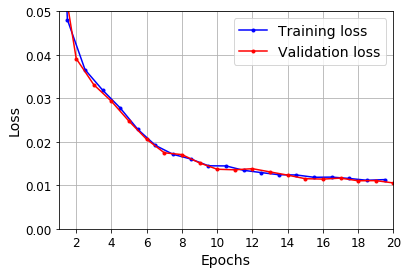

In [37]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [38]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

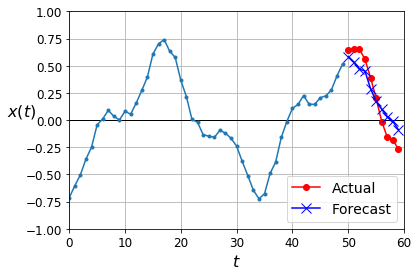

In [39]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [40]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [41]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, batch_size=32,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0498 - last_time_step_mse: 0.0388 - val_loss: 0.0416 - val_last_time_step_mse: 0.0321
Epoch 2/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0388 - last_time_step_mse: 0.0279 - val_loss: 0.0342 - val_last_time_step_mse: 0.0217
Epoch 3/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0327 - last_time_step_mse: 0.0217 - val_loss: 0.0288 - val_last_time_step_mse: 0.0173
Epoch 4/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0289 - last_time_step_mse: 0.0174 - val_loss: 0.0281 - val_last_time_step_mse: 0.0171
Epoch 5/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0269 - last_time_step_mse: 0.0150 - val_loss: 0.0256 - val_last_time_step_mse: 0.0126
Epoch 6/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0241 - last_time_step_mse: 0.0114 - val_lo

In [46]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


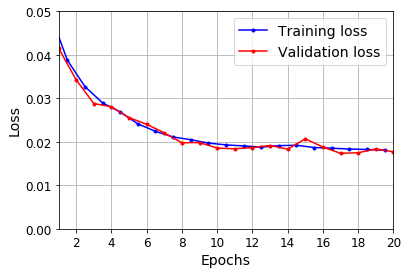

In [43]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [44]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

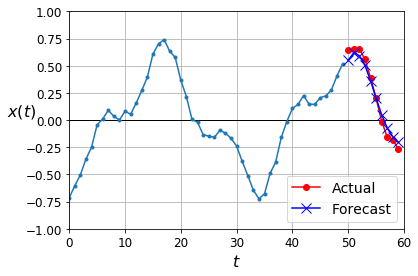

In [45]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# LSTMs

In [78]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [79]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 20)          1760      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 10)          210       
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 647us/sample - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0372
Epoch 2/20
7000/7000 [==============================] - 2s 218us/sample - loss: 0.0480 - last_time_step_mse: 0.0281 - val_loss: 0.0423 - val_last_time_step_mse: 0.0211
Epoch 3/20
7000/7000 [==============================] - 2s 222us/sample - loss: 0.0390 - last_time_step_mse: 0.0182 - val_loss: 0.0371 - val_last_time_step_mse: 0.0164
Epoch 4/20
7000/7000 [==============================] - 2s 221us/sample - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0335 - val_last_time_step_mse: 0.0143
Epoch 5/20
7000/7000 [==============================] - 2s 217us/sample - loss: 0.0325 - last_time_step_mse: 0.0136 - val_loss: 0.0314 - val_last_time_step_mse: 0.0124
Epoch 6/20
7000/7000 [==============================] - 2s 222us/sample - loss: 0.0308 - last_time_step_mse: 0.0

In [81]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 0s 109us/sample - loss: 0.0240 - last_time_step_mse: 0.0086


[0.024016655758023264, 0.008551417]

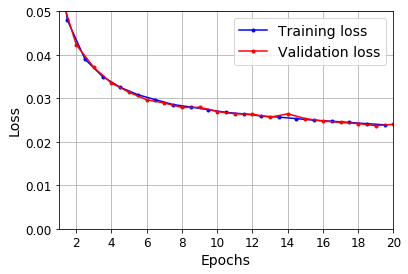

In [82]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [83]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

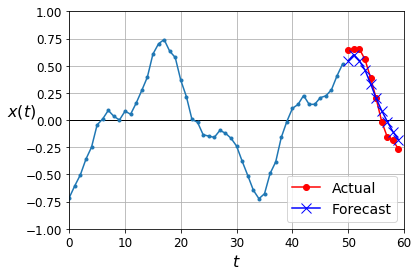

In [84]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [85]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [86]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 20)          1380      
_________________________________________________________________
gru_1 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 10)          210       
Total params: 4,110
Trainable params: 4,110
Non-trainable params: 0
_________________________________________________________________


In [87]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 593us/sample - loss: 0.0742 - last_time_step_mse: 0.0663 - val_loss: 0.0523 - val_last_time_step_mse: 0.0421
Epoch 2/20
7000/7000 [==============================] - 1s 210us/sample - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0327
Epoch 3/20
7000/7000 [==============================] - 1s 210us/sample - loss: 0.0418 - last_time_step_mse: 0.0305 - val_loss: 0.0391 - val_last_time_step_mse: 0.0271
Epoch 4/20
7000/7000 [==============================] - 1s 207us/sample - loss: 0.0373 - last_time_step_mse: 0.0249 - val_loss: 0.0343 - val_last_time_step_mse: 0.0205
Epoch 5/20
7000/7000 [==============================] - 1s 207us/sample - loss: 0.0327 - last_time_step_mse: 0.0179 - val_loss: 0.0313 - val_last_time_step_mse: 0.0158
Epoch 6/20
7000/7000 [==============================] - 1s 206us/sample - loss: 0.0308 - last_time_step_mse: 0.0

In [88]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 0s 97us/sample - loss: 0.0241 - last_time_step_mse: 0.0103


[0.024071005389094353, 0.010298315]

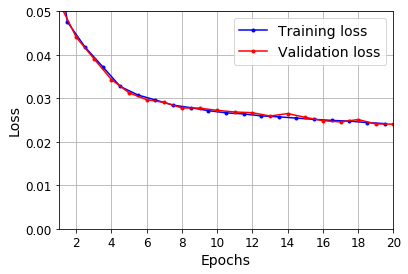

In [89]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [90]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

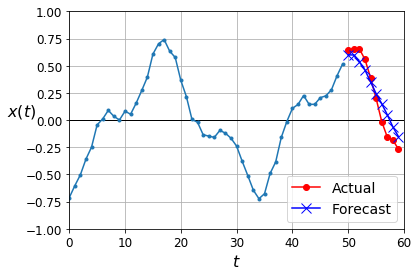

In [91]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [94]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 563us/sample - loss: 0.0683 - last_time_step_mse: 0.0605 - val_loss: 0.0482 - val_last_time_step_mse: 0.0405
Epoch 2/20
7000/7000 [==============================] - 1s 189us/sample - loss: 0.0416 - last_time_step_mse: 0.0342 - val_loss: 0.0368 - val_last_time_step_mse: 0.0283
Epoch 3/20
7000/7000 [==============================] - 2s 248us/sample - loss: 0.0334 - last_time_step_mse: 0.0251 - val_loss: 0.0307 - val_last_time_step_mse: 0.0220
Epoch 4/20
7000/7000 [==============================] - 1s 191us/sample - loss: 0.0273 - last_time_step_mse: 0.0172 - val_loss: 0.0251 - val_last_time_step_mse: 0.0141
Epoch 5/20
7000/7000 [==============================] - 1s 192us/sample - loss: 0.0243 - last_time_step_mse: 0.0134 - val_loss: 0.0238 - val_last_time_step_mse: 0.0128
Epoch 6/20
7000/7000 [==============================] - 1s 193us/sample - loss: 0.0230 - last_time_step_mse: 0.0

In [97]:
model.evaluate(X_valid, Y_valid[:, 3::2])

2000/2000 [==============================] - 1s 264us/sample - loss: 0.0173 - last_time_step_mse: 0.0067


[0.017292517945170404, 0.00672329]

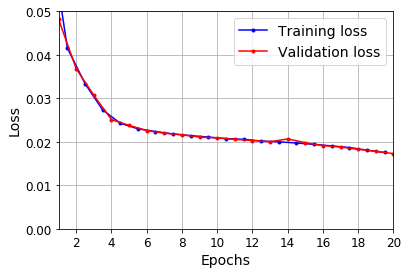

In [98]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [99]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

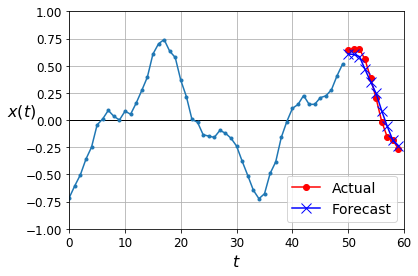

In [100]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()